In [2]:
#importing libaries
import re, numpy as np, pandas as pd
from pprint import pprint
import os
import json
import torch
# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 
                   'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see',
                   'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 
                   'right', 'line', 'even', 'also', 'may', 'take', 'come'])

In [3]:
with open('sherlock_train_v1_1.json', 'r') as f:
  data = json.load(f)

papers = pd.json_normalize(data)

In [51]:
df = papers[['inputs.confidence','targets.inference', 'inputs.clue']]


In [52]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df['targets.inference'].values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

<>:3: DeprecationWarning: invalid escape sequence \S
<>:4: DeprecationWarning: invalid escape sequence \s
<>:3: DeprecationWarning: invalid escape sequence \S
<>:4: DeprecationWarning: invalid escape sequence \s
<ipython-input-52-ce5845abd159>:3: DeprecationWarning: invalid escape sequence \S
  sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
<ipython-input-52-ce5845abd159>:4: DeprecationWarning: invalid escape sequence \s
  sent = re.sub('\s+', ' ', sent)  # remove newline chars


[['it', 'recently', 'snowed']]


In [53]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load("en_core_web_sm")
    #nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [54]:
data_ready

[['recently', 'snow'],
 ['cold', 'outside'],
 ['horse', 'horseback', 'riding'],
 ['company', 'photo'],
 ['airplane', 'manufacture', 'long', 'time'],
 ['rain'],
 ['move', 'people', 'floor'],
 ['name', 'store'],
 ['open', 'air', 'mall'],
 [],
 ['plant', 'sale'],
 ['retail', 'location'],
 ['light', 'night'],
 ['build', 'multiple_room'],
 ['man', 'literate'],
 ['carry', 'bag'],
 ['car',
  'directly_face',
  'traffic',
  'light',
  'expect',
  'remain_still',
  'currently'],
 ['sun', 'set'],
 ['winter'],
 ['strap', 'hold', 'thing', 'place'],
 ['hospital'],
 ['computers_help', 'thing', 'quick'],
 ['rest'],
 ['animal', 'farm'],
 ['hungry'],
 ['warehouse', 'dark', 'light', 'people'],
 ['animal', 'ship', 'somewhere'],
 ['person', 'watch', 'animal', 'sure', 'wrong'],
 ['eating', 'leave'],
 ['bathroom'],
 ['bathroom', 'clean'],
 ['daytime'],
 ['store'],
 ['man', 'stop'],
 ['person', 'sit'],
 ['person', 'play', 'food', 'active', 'imagination'],
 ['food', 'serve', 'child'],
 ['person', 'create', 's

/home/qin/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/home/qin/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/home/qin/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/home/qin/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (

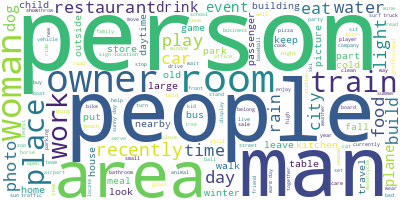

In [50]:
long_string = ','.join([element for sublist in data_ready for element in sublist])
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [55]:
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())


In [ ]:
# def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
#     # Init output
#     sent_topics_df = pd.DataFrame()

#     # Get main topic in each document
#     for i, row_list in enumerate(ldamodel[corpus]):
#         row = row_list[0] if ldamodel.per_word_topics else row_list            
#         # print(row)
#         row = sorted(row, key=lambda x: (x[1]), reverse=True)
#         # Get the Dominant topic, Perc Contribution and Keywords for each document
#         for j, (topic_num, prop_topic) in enumerate(row):
#             if j == 0:  # => dominant topic
#                 wp = ldamodel.show_topic(topic_num)
#                 topic_keywords = ", ".join([word for word, prop in wp])
#                 sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
#             else:
#                 break
#     sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

#     # Add original text to the end of the output
#     contents = pd.Series(texts)
#     sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
#     return(sent_topics_df)


# df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# # Format
# df_dominant_topic = df_topic_sents_keywords.reset_index()
# df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
# df_dominant_topic.head(5)

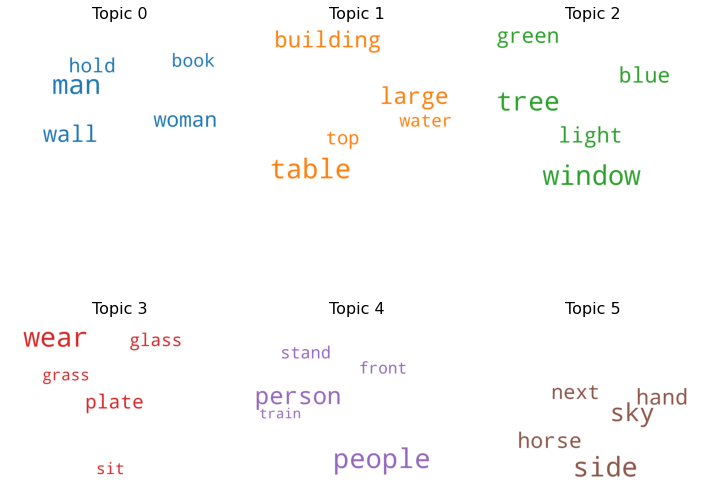

In [ ]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=5,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [ ]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.092350  0.290429       1        1  17.743213
0     -0.219208 -0.239089       2        1  17.673043
1      0.282125 -0.071156       3        1  17.198030
3     -0.067307 -0.046150       4        1  16.689579
2     -0.041467  0.098719       5        1  15.621294
5      0.138208 -0.032753       6        1  15.074842, topic_info=         Term        Freq       Total Category  logprob  loglift
75     people  339.000000  339.000000  Default  30.0000  30.0000
34       wear  264.000000  264.000000  Default  29.0000  29.0000
11     person  261.000000  261.000000  Default  28.0000  28.0000
56      table  247.000000  247.000000  Default  27.0000  27.0000
28        man  245.000000  245.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
318      fill   20.131370   20.933624   Topic6  -4.7850   1.8531
880  shoulder   21.256304   22.106967   Topic6  -4.7307   1.8529
791     clean   31.294985   32.598580   Topic6  -4.3439   1.8513
233  suitcase   27.061561   28.220247   Topic6  -4.4892   1.8502
793     asian   25.769139   30.908736   Topic6  -4.5381   1.7103

[223 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
552       1  0.972400       air
298       4  0.966534  airplane
35        3  0.982098      area
793       3  0.097060     asian
793       4  0.032353     asian
...     ...       ...       ...
30        2  0.994221     woman
475       3  0.987956      wood
227       3  0.983116    wooden
258       4  0.985749     write
121       5  0.957740    yellow

[208 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 2, 4, 3, 6])